# Creating a smoothed dataset using Whittaker


In this notebook, we use Whittaker algorithm is available in the FuseTS toolbox as a user-defined-function (UDF) to create a smoothed time series. It employs a discrete penalized least squares algorithm that fits a smooth series, denoted as z, to the original data series, denoted as y.


In [9]:
import itertools
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import openeo
import pandas as pd
import xarray
from ipyleaflet import GeoJSON, Map, basemaps
from openeo.processes import eq
from openeo.rest.conversions import timeseries_json_to_pandas

from fusets.analytics import phenology
from fusets.mogpr import mogpr_1D
from fusets.whittaker import whittaker

warnings.filterwarnings("ignore")

The first step is to connect to an openEO backend and authenticate with the Copernicus Dataspace Ecosystem's credentials.

In [11]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Next we define the area of interest, in this case an extent, for which we would like to fetch time series data.

In [12]:
year = 2019
spat_ext = {
    "coordinates": [
        [
            [-4.875091217039325, 41.77290587433312],
            [-4.872773788450457, 41.77290587433312],
            [-4.872773788450457, 41.77450614847532],
            [-4.875091217039325, 41.77450614847532],
            [-4.875091217039325, 41.77290587433312],
        ]
    ],
    "type": "Polygon",
}
temp_ext = [f"{year}-01-01", f"{year}-12-30"]

In [13]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 16

m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m

Map(center=[41.773545983990005, -4.874164245603778], controls=(ZoomControl(options=['position', 'zoom_in_text'…

We will be working with with the rapeseed from 2019, located in the Nothern Spain.

We will create an openEO process to calculate the NDVI time series for our area of interest. First we begin by using the `SENTINEL2_L2A` collection, and apply a `Sen2Cor` cloud masking algorithm to remove any interfering clouds before calculating the NDVI values.

In [14]:
s2 = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spat_ext,
    temporal_extent=temp_ext,
    bands=["B04", "B08", "SCL"],
)
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
s2 = s2.mask_polygon(spat_ext)
ndvi_cube = s2.ndvi(red="B04", nir="B08", target_band="NDVI")

Now that we have calculated the NDVI time series for our area of interest, we can request openEO to download the result to our local storage. This will allow us to access the file and use it for further analysis in this notebook.

In [16]:
ndvi_output_file = "raw_s2_ndvi_field.nc"

# batch job

ndvi_job = ndvi_cube.execute_batch(
    ndvi_output_file, title=f"FUSETS- Raw NDVI")

# load the dataset and check it's structure
raw_ndvi_ds = xarray.load_dataset(ndvi_output_file)
raw_ndvi_ds

0:00:00 Job 'j-2310278cb5a54d02b66f2365b3eb484e': send 'start'
0:00:12 Job 'j-2310278cb5a54d02b66f2365b3eb484e': created (progress N/A)
0:00:18 Job 'j-2310278cb5a54d02b66f2365b3eb484e': created (progress N/A)
0:00:24 Job 'j-2310278cb5a54d02b66f2365b3eb484e': created (progress N/A)
0:00:32 Job 'j-2310278cb5a54d02b66f2365b3eb484e': running (progress N/A)
0:00:43 Job 'j-2310278cb5a54d02b66f2365b3eb484e': running (progress N/A)
0:00:56 Job 'j-2310278cb5a54d02b66f2365b3eb484e': running (progress N/A)
0:01:15 Job 'j-2310278cb5a54d02b66f2365b3eb484e': running (progress N/A)
0:01:35 Job 'j-2310278cb5a54d02b66f2365b3eb484e': running (progress N/A)
0:01:59 Job 'j-2310278cb5a54d02b66f2365b3eb484e': running (progress N/A)
0:02:29 Job 'j-2310278cb5a54d02b66f2365b3eb484e': running (progress N/A)
0:03:07 Job 'j-2310278cb5a54d02b66f2365b3eb484e': finished (progress N/A)


<xarray.Dataset>
Dimensions:  (t: 31, x: 21, y: 19)
Coordinates:
  * t        (t) datetime64[ns] 2019-01-27 2019-02-11 ... 2019-12-18 2019-12-28
  * x        (x) float64 3.442e+05 3.442e+05 3.442e+05 ... 3.443e+05 3.444e+05
  * y        (y) float64 4.626e+06 4.626e+06 4.626e+06 ... 4.626e+06 4.626e+06
Data variables:
    crs      |S1 b''
    B04      (t, y, x) float32 nan 1.212e+03 1.226e+03 1.236e+03 ... nan nan nan
    B08      (t, y, x) float32 nan 1.934e+03 1.964e+03 1.982e+03 ... nan nan nan
    SCL      (t, y, x) float32 nan 5.0 5.0 5.0 5.0 5.0 ... nan nan nan nan nan
    NDVI     (t, y, x) float32 nan 0.2295 0.2313 0.2318 ... nan nan nan nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.18.0a1
    description:  
    title:

Plot the raw NDVI time series, averaged across the parcel


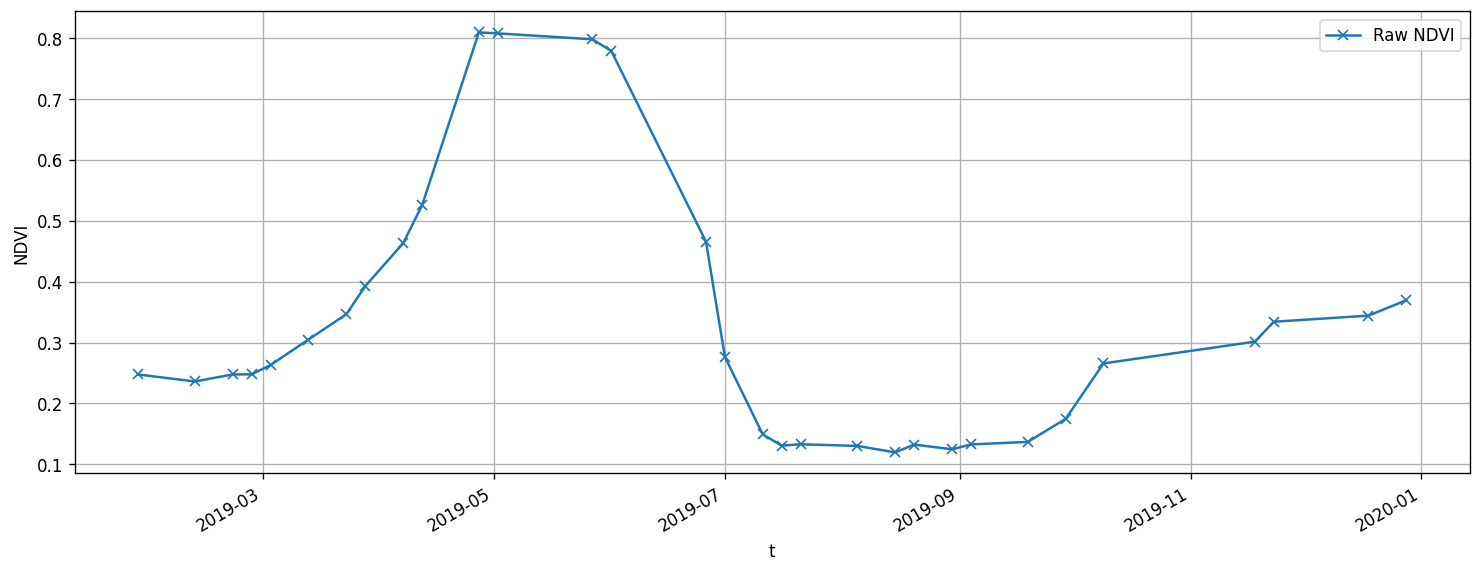

In [17]:
raw_ndvi = raw_ndvi_ds.NDVI.rename({"t": "time"})

fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Raw NDVI")
ax.legend()
ax.grid()

In [18]:
# Make a prediction every 5 days
# to use the same dates as in the raw time series, just set the `prediction_period` to `None`
smoothed = whittaker(raw_ndvi, prediction_period="P5D", smoothing_lambda=10)

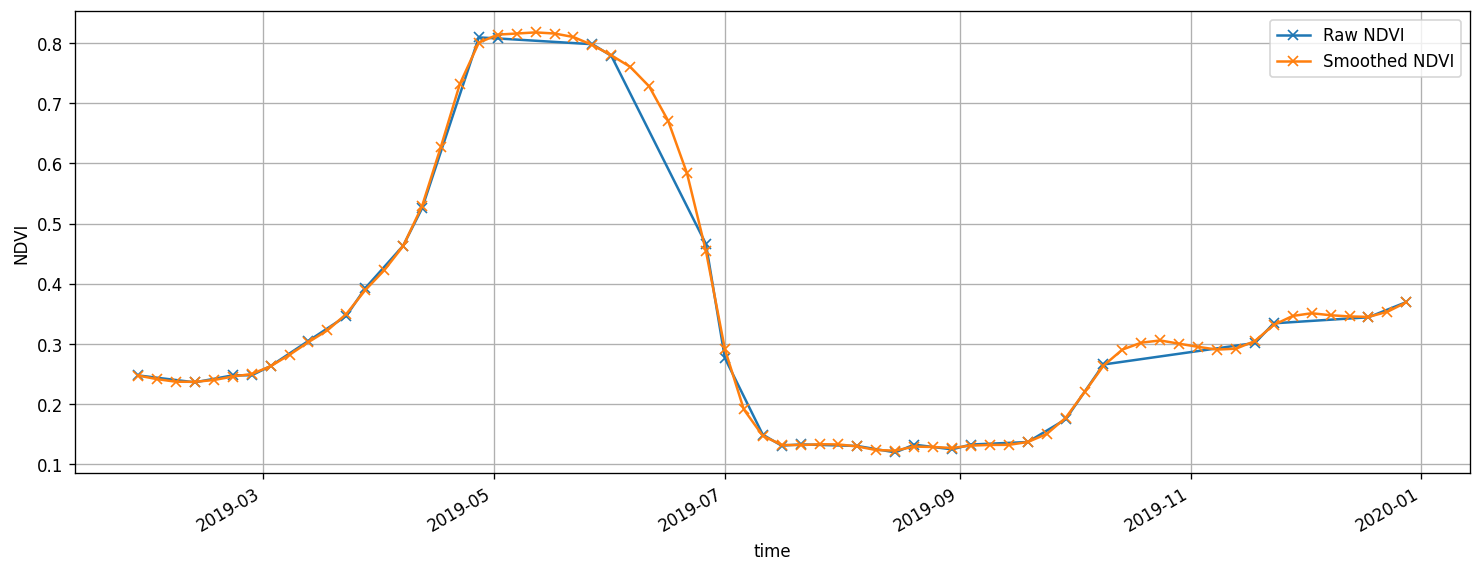

In [19]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Raw NDVI", color="C0")
smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Smoothed NDVI", color="C1")
ax.legend()
ax.grid()